# Optimal control transport of trapped ions 
Transport of trapped ions is a key tool in trapped ion experiments. The task of moving one ion from A to B in the trap can be split into a series of interconnected optimization problems.

Reference: Optimal control transport of neutral atoms in optical tweezers at finite temperature, 
https://doi.org/10.1103/PhysRevResearch.6.033282

1. Reproduce the optimal control transport task discussed in the paper for the case of trapped ions. Formulate the problem as the 1D transport of one particle in a harmonic potential (rather than gaussian) and find a trajectory with minimal excitation using realistic trap parameters. You can use the python package referenced in the paper https://pypi.org/project/quocs-lib/ <br>
Bonus: transport two ions, use two control parameters (position and trap frequency), and minimize the excitation of both the COM and STR mode. 
2. Implement the transport in a realistic ion trap. Build an electrostatic model for a surface electrode trap, and find the voltage waveforms that reproduce the optimal control trajectory. I suggest using the python package pytrans https://pypi.org/project/pytrans/ (and related 
examples) 

By the due date please submit the presentation and the code. The final presentation will be 20 minutes long and you have to present the problem, methods and results. A final question on the program of the Quantum Information and Computing course will conclude the exam.

**Import zone**

In [1]:
import numpy as np
import debugger as db
import auxiliary_functions as aux
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm

In [2]:
# ===========================================================================================================
# PARAM CLASS
# ===========================================================================================================

class Param:
  """
  Param: 
    Container for holding all simulation parameters.
  """
  def __init__(self,
               x_min: float,
               x_max: float,
               num_x: int,
               tsim: float,
               num_t: int,
               tc: float,
               num_tc:int,
               im_time: bool = False) -> None:
    """
    __init__ : 
      Initialize simulation parameters.

    Parameters
    ----------
    x_min : float
      Minimum spatial value.
    x_max : float
      Maximum spatial value.
    num_x : int
      Number of spatial grid points.
    tsim : float
      Total simulation time.
    num_t : int
      Number of time steps.
    im_time : bool, optional
      Whether to use imaginary time evolution. Default is False.
    """
    # Initialization
    self.x_min = x_min
    self.x_max = x_max
    self.num_x = num_x
    self.tsim = tsim
    self.num_t = num_t
    self.tc = tc
    self.num_tc = num_tc
    self.im_time = im_time

    # Infinitesimal quantities (space, time, momentum)
    self.dx = (x_max - x_min) / num_x
    self.dt = tsim / num_t
    self.dk = 2 * np.pi / (x_max - x_min)
    
    # Check consistency in time-grids
    assert (np.allclose(self.dt, tc / num_tc))

    # Spatial grid
    self.x = np.linspace(x_min + 0.5 * self.dx, x_max - 0.5 * self.dx, num_x)

    # Momentum grid -> For FFT, frequencies are in this order
    self.k = np.fft.fftfreq(num_x, d=self.dx) * 2 * np.pi

    # validation check
    self._validate()

  def _validate(self) -> None:
    """
    _validate :
      Check for common errors in parameter initialization.
    """
    if self.num_x <= 0 or self.num_t <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: num_x and num_t must be positive integers.", stop=True)
    if self.x_max <= 0 or self.tsim <= 0:
      db.checkpoint(debug=True, msg1="INITIALIZATION", msg2="ValueError: xmax and tsim must be positive values.", stop=True)

In [134]:
def project_onto_energy_basis(psi, x, num_wfcs, omega, delta_x):
  """
  Project the wavefunction `psi` onto the energy eigenbasis (Hermite functions).
  """
  # Initialize coefficients in energy basis
  coeff = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  true_psi = aux.harmonic_wfc(x - delta_x, omega, num_wfcs)
  
  # Loop over energy levels and compute overlap
  for n in range(num_wfcs):
    for i in range(num_wfcs):
      coeff[i, n] = true_psi[i] @ np.conj(psi[n])
  return np.round(np.real_if_close(coeff), 4)

def density_matrix(probabilities, wavefunctions, x, num_wfcs, omega, delta_x):
  rho = 0
  rho = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  coefficients = project_onto_energy_basis(wavefunctions, x, num_wfcs, omega, delta_x)
  
  for i in range(num_wfcs):
    rho += probabilities[i] * np.outer(coefficients[i], np.conj(coefficients[i]))
    
  rho /= np.trace(rho)
  rho = np.nan_to_num(rho, nan=0.0)

  return np.round(np.real_if_close(rho), 4)

def calculate_energies(wavefunctions, potential, par: Param):
  energies = []
  
  for wfc in wavefunctions:
    # Creating momentum and conjugate wavefunctions.
    wfc_k = np.fft.fft(wfc)
    wfc_c = np.conj(wfc)
    
    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * potential * wfc
    
    # Integrating over all space
    energy_final = sum(energy_k + energy_r).real
    
    # Store the energy
    energies.append(energy_final)
  
  return energies

def calculate_probabilities(energies, T):
  # Store probabilities for mixed state density matrix
  probs = [np.exp(-energies[i] / T) for i in range(len(energies))]
  probs /= np.sum(probs)
    
  return probs

In [4]:
# ===========================================================================================================
# OPERATORS CLASS
# ===========================================================================================================

class Operators:
  """
  Container for holding operators and wavefunction coefficients.
  """
  def __init__(self, 
               res: int,
               omega: float = 1.0,
               num_wfcs: int = 1,
               T: float = 10e-6,
               r_t: list[float] = None,
               par: Param = None) -> None:

    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.V = np.empty(res, dtype=complex)  # Potential operator
    self.R = np.empty(res, dtype=complex)  # Real-space propagator
    self.K = np.empty(res, dtype=complex)  # Momentum-space propagator
    self.wfcs = np.empty((num_wfcs+1, res), dtype=complex)  # Wavefunction coefficients
    self.shifted_wfcs = np.empty((num_wfcs+1, res), dtype=complex)  # Shifted wavefunction coefficients
    
    # Store finite temperature
    self.T = T
    
    # Energy list for  (finite temperature case)
    self.energies = []
    self.probabilities = []
    
    # Density matrices
    self.rho = []
    self.shifted_rho = []
    
    # Infidelity
    self.average_infidelity = 0
    
    # Store time-dependent drive (default to no potential if None)
    self.r_t = r_t if r_t is not None else np.zeros(par.num_t)
    
    # Store angular frequency
    self.omega = omega
    
    # Store maximum order of the Hermite polynomial
    self.num_wfcs = num_wfcs

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par)


  def reinitialize_operators(self, par: Param, pulse) -> None:
    """Reinitialize the operators with a new Param object."""
    # Reinitialize potential, propagators, and wavefunctions
    self.V = np.empty(self.V.shape, dtype=complex)
    self.R = np.empty(self.R.shape, dtype=complex)
    self.K = np.empty(self.K.shape, dtype=complex)
    self.wfcs = np.empty((self.num_wfcs, self.V.shape[0]), dtype=complex)
    self.shifted_wfcs = np.zeros((self.num_wfcs, self.V.shape[0]))

    # Reset density matrices and energy lists
    self.energies = []
    self.probabilities = []
    self.rho = []
    self.shifted_rho = []

    # Store new time-dependent drive
    self.r_t = pulse

    # Call the initialization function with the new parameter object
    self._initialize_operators(par)

  def _initialize_operators(self, par: Param) -> None:
    # Initial and final time-dependent offset
    r0 = self.r_t[0]
    rf = self.r_t[-1]

    # Quadratic potential with offset
    self.V = 0.5 * (par.x - r0) ** 2 * self.omega **2

    # Wavefunctions and shifted wavefunctions based on analytical solution for the harmonic oscillator
    self.wfcs = aux.harmonic_wfc(par.x - r0, self.omega, self.num_wfcs)
    self.shifted_wfcs = aux.harmonic_wfc(par.x - rf, self.omega, self.num_wfcs)
    
    # Coefficient for imaginary or real time evolution
    coeff = 1 if par.im_time else 1j

    # Momentum and real-space propagators
    self.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    self.R = np.exp(-0.5 * self.V * par.dt * coeff)
    
    # Energies and probabilities for mixed state density matrix
    self.energies = calculate_energies(self.wfcs, self.V, par)
    self.probabilities = calculate_probabilities(self.energies, self.T)
    
    # Density matrix
    self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, r0)
    self.shifted_rho = density_matrix(self.probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, rf)


  def get_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.wfcs[n]

  def get_shifted_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.shifted_wfcs[n]

      
  def infidelity(self):
    overlap = np.trace(sqrtm(sqrtm(self.rho) @ self.shifted_rho @ sqrtm(self.rho)))
    infidelity = 1 - abs(overlap) ** 2
    #infidelity = np.maximum(0, infidelity)
    infidelity = np.clip(infidelity, 1e-3, 1)
    return infidelity
  
  
  def split_op(self, par: Param, fixed_potential: bool = False):
    # Set coefficient for real or imaginary time evolution
    coeff = 1 if par.im_time else 1j
    
    timesteps = par.num_t if not fixed_potential else par.num_tc
    drive = self.r_t if not fixed_potential else np.full(par.num_tc, self.r_t[-1])

    infidelities = []
    
    # Loop over the number of timesteps    
    for i in range(timesteps):
      # If not fixed, update the time-dependent potential
      self.V = 0.5 * (par.x - drive[i]) ** 2 * self.omega ** 2

      # Update the real-space propagator
      self.R = np.exp(-0.5 * self.V * par.dt * coeff)

      # Loop over all wavefunctions
      for n in range(self.num_wfcs):
        # Half-step in real space
        self.wfcs[n] *= self.R

        # Full step in momentum space
        self.wfcs[n] = np.fft.fft(self.wfcs[n])
        self.wfcs[n] *= self.K
        self.wfcs[n] = np.fft.ifft(self.wfcs[n])

        # Final half-step in real space
        self.wfcs[n] *= self.R
      
      if fixed_potential:
        # Compute updated quantities
        self.energies = calculate_energies(self.wfcs, self.V, par)
        self.probabilities = calculate_probabilities(self.energies, self.T)
        self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, drive[i])
        infidelities.append(self.infidelity())
      
    self.average_infidelity = np.mean(infidelities) if fixed_potential else 0

  def time_evolution(self, par: Param, fixed_potential: bool = False):
    # Apply split operator to wfcs
    self.split_op(par, fixed_potential)
    rf = self.r_t[-1] 
    self.shifted_rho = density_matrix(self.probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, rf)
    
    if not fixed_potential:
      # Compute updated quantities
      self.energies = calculate_energies(self.wfcs, self.V, par)
      self.probabilities = calculate_probabilities(self.energies, self.T)
      self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, rf)

In [5]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 5000
tsim = 10
tc = 10
desired_dt = 0.01
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [6]:
opr.rho

array([[0.64391848+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.23688424+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.08714489+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.03205238+0.j]])

In [7]:
print("Energies\n", opr.energies)

Energies
 [0.49999999996066785, 1.5000005449931404, 2.4999999566493933, 3.5002005868190245]


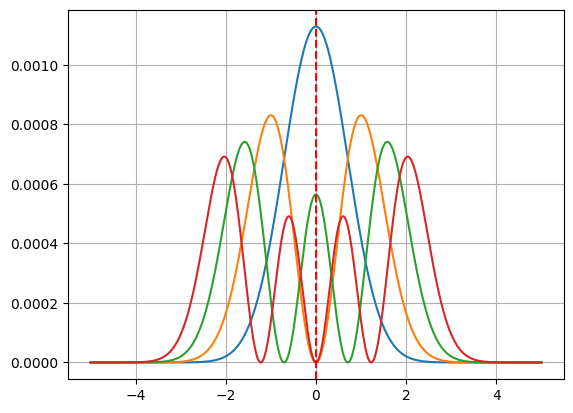

In [8]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)
  
plt.axvline(opr.r_t[0], color='red', linestyle='--')
#plt.plot(par.x, opr.V)
#plt.ylim(-0.1, 0.6)
plt.grid()
plt.show()

In [9]:
opr.infidelity()

0.0010000000000000000208

In [10]:
opr.time_evolution(par, fixed_potential=False)

In [11]:
opr.rho

array([[ 6.39811513e-01+0.j        , -1.55907084e-02-0.05272903j,
        -2.78687269e-03+0.00182978j,  1.16823063e-04+0.00013209j],
       [-1.55907084e-02+0.05272903j,  2.39964544e-01+0.j        ,
        -8.22325440e-03-0.02781694j, -1.77527056e-03+0.0011481j ],
       [-2.78687269e-03-0.00182978j, -8.22325440e-03+0.02781694j,
         8.93241863e-02+0.j        , -3.85844085e-03-0.0130384j ],
       [ 1.16823063e-04-0.00013209j, -1.77527056e-03-0.0011481j ,
        -3.85844085e-03+0.0130384j ,  3.08997567e-02+0.j        ]])

In [12]:
print("Energies\n", opr.energies)

Energies
 [0.5184953337364587, 1.5189660733927817, 2.5262906476899496, 3.5934877334653867]


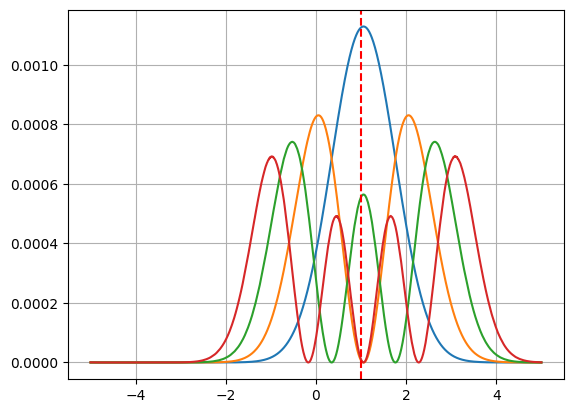

In [13]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)

plt.grid()
plt.show()

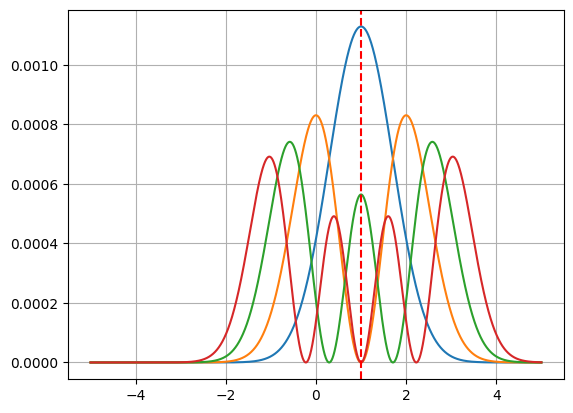

In [14]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [15]:
opr.infidelity()

0.007636255106451181145

In [16]:
opr.time_evolution(par, fixed_potential=True)

In [17]:
opr.rho

array([[ 6.64089201e-01+0.j        , -1.62835130e-02-0.0550568j ,
        -2.78193795e-03+0.00179862j,  1.16204283e-04+0.00010922j],
       [-1.62835130e-02+0.0550568j ,  2.46689166e-01+0.j        ,
        -9.19296862e-03-0.03112219j, -1.92751539e-03+0.00124882j],
       [-2.78193795e-03-0.00179862j, -9.19296862e-03+0.03112219j,
         7.83510676e-02+0.j        , -4.52900267e-03-0.01531236j],
       [ 1.16204283e-04-0.00010922j, -1.92751539e-03-0.00124882j,
        -4.52900267e-03+0.01531236j,  1.08705649e-02+0.j        ]])

In [18]:
print("Energies\n", opr.energies)

Energies
 [0.5187569948622177, 1.5272715272292885, 2.6998437325612383, 4.985105396400174]


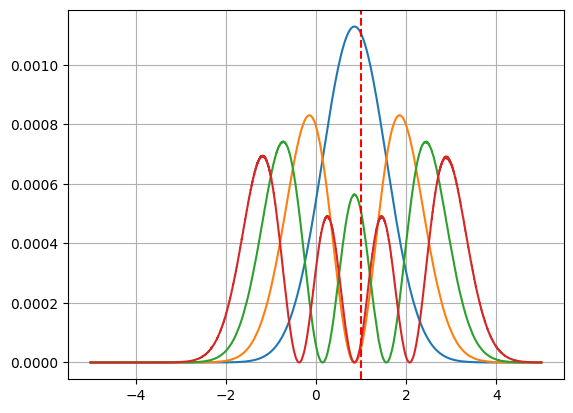

In [19]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [20]:
opr.infidelity()

0.009948746830541803799

In [21]:
opr.average_infidelity

0.01152578420346815063

In [22]:
from quocslib.utils.AbstractFoM import AbstractFoM

class OptimalControl(AbstractFoM):
  def __init__(self, operator: Operators, par: Param):
    self.opr = operator  # Pass in the Operators instance
    self.par = par       # Pass in the Param instance
    self.evolution_is_computed = False
        
  def t_ev(self, pulses_list, time_grids_list, parameter_list):
    time_grid = time_grids_list[0]
    self.par.dt = time_grid[-1] / len(time_grid)
    self.par.num_t = len(time_grid)
    
    self.opr.reinitialize_operators(self.par, pulses_list[0])
    
    # Perform the time evolution for all wavefunctions
    self.opr.time_evolution(self.par, fixed_potential=False)
    self.opr.time_evolution(self.par, fixed_potential=True)

    print(self.opr.energies)
    
    # Save flag
    self.evolution_is_computed = True
  
  
  def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
    if pulses is None:
      raise ValueError("Missing 'pulses' in get_FoM arguments")
    
    # Perform the time evolution
    if not self.evolution_is_computed:
      self.t_ev(pulses, timegrids, parameters)
    self.evolution_is_computed = False
    
    # Compute figure of merit
    FoM = self.opr.average_infidelity
    
    return {"FoM": FoM}

In [135]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 5000
tsim = 5
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 8
T = 1
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [136]:
optimization_dictionary = {"optimization_client_name": "OptimalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 3
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings


pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 100.0,
           "lower_limit": -100.0,
           "bins_number": 2000,
           "amplitude_variation": 30,
           "time_name": "time_1"}
           
#pulse_x["scaling_function"] = {
#               "function_type": "python_file",
#               "file_path": "functions",
#               "function_name": "shape_function",
#               "path_mode": "relative"
#             }

pulse_x["initial_guess"] = {
               "function_type": "python_file",
               "file_path": "functions",
               "function_name": "initial_guess_function",
               "path_mode": "relative"
             }


pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 2,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 20.0
                }
            }

#pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

#pulse_x["basis"] = {
#  "basis_name": "Fourier",
#  "basis_vector_number": 5,  # Adjust based on resolution needs
#  "random_super_parameter_distribution": {
#    "distribution_name": "Uniform",
#    "lower_limit": 0.01,
#    "upper_limit": 5.0
#  }
#}


time1 = {"time_name": "time_1",
         "initial_value": 5.0 }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]
optimization_dictionary["shaping_options"] = [
            "add_base_pulse",
            "add_new_update_pulse",
            #"scale_pulse",
            "add_initial_guess",
            "limit_pulse"
        ]


from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, OptimalControl(opr, par))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.63


INFO     oc_logger    Direct search start time has been reset.
[0.566810529426004, 1.5987762307233258, 2.7876900521565715, 4.525658758546257, 7.917606376264402, 14.74323929855986, 21.260416248532973, 19.294019788277613]
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.04734807967027382
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.04734807967027382


/tmp/ipykernel_442/2718060526.py:51: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)
/tmp/ipykernel_442/2718060526.py:23: RuntimeWarning: invalid value encountered in divide
  rho /= np.trace(rho)


[9544.027793511113, 9885.587947518774, 8717.542214176292, 8929.716403297587, 9651.074008524804, 9594.94891639424, 8601.109138083952, 6657.99578084141]
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 1.0
INFO     oc_logger    Setting is_running state: False
[22368.59355544156, 22325.754658604994, 22282.63567271837, 22239.231387497093, 22195.53645290028, 22151.545374392048, 22107.25250800796, 22062.652055218532]
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 1.0
INFO     oc_logger    SI 1 finished - Number of evaluations: 5, Best FoM: 0.04734807967027382, Terminate reason: Change-based stopping criterion reached.

INFO     oc_logger    Figure of merit : 0.04734807967027382
INFO     oc_logger    Std : 0.0
INFO     oc_logger    total number of function evaluations : 3
INFO     oc_logger    dcrab_freq_list : [[[2.524201841415593, 15.941722406109474]]]
INFO     oc_logger    dcrab_para_list : [array([0., 0., 

Text(0, 0.5, 'Amplitude')

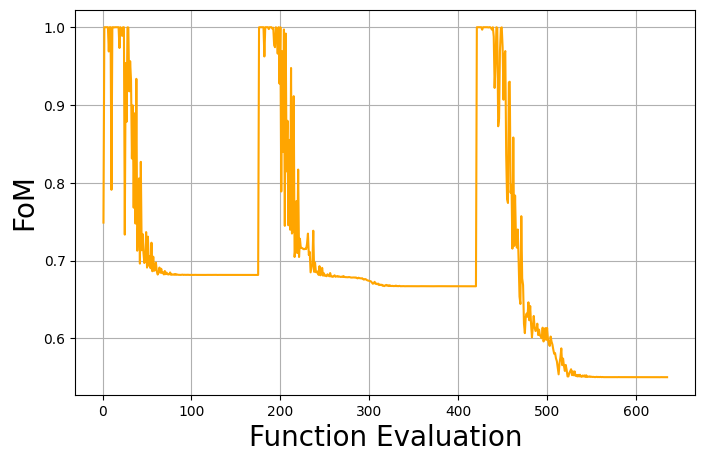

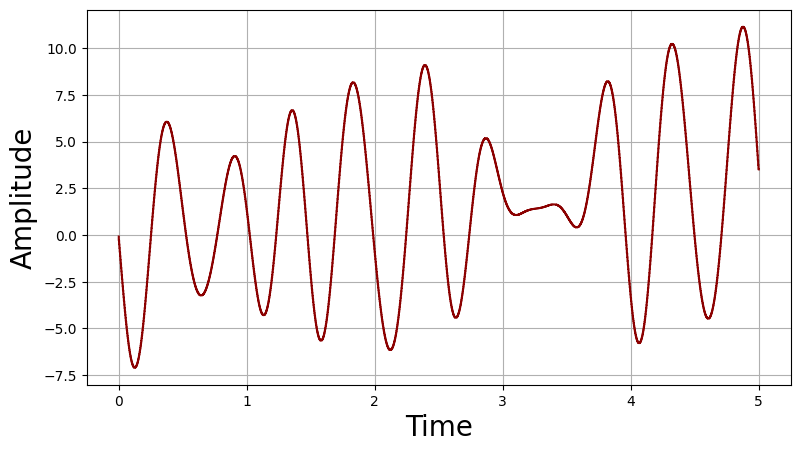

In [70]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
#ax.set_yscale("log")
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [71]:
pulse

array([-0.07990515, -0.28627087, -0.49341636, ...,  4.01202785,
        3.76380538,  3.51529888])

In [72]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 5000
tsim = 10
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 8
T = 1

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [73]:
opr.energies

[0.500000001777339,
 1.5000006247201676,
 2.5000017799451526,
 3.5002243942023266,
 4.500241641984391,
 5.520114879000934,
 6.510235877671374,
 8.193554086575247]

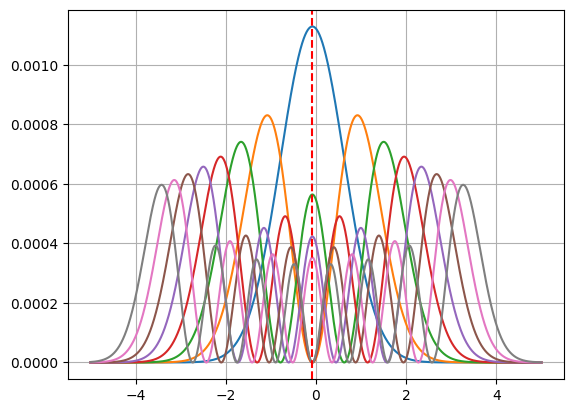

In [75]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [76]:
opr.time_evolution(par, fixed_potential=False)

/tmp/ipykernel_9344/2265382712.py:49: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)


In [77]:
opr.energies

[4231.507241980431,
 4307.732100703824,
 4098.068050837966,
 4530.8411302308095,
 3568.1630455150407,
 3465.397455515303,
 3622.128527539487,
 4441.760049701631]

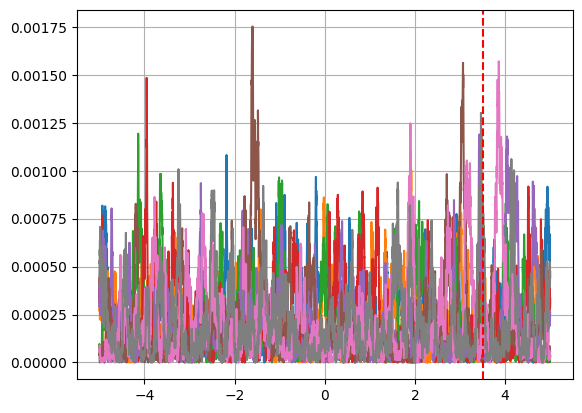

In [79]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [80]:
opr.infidelity()

1.0

In [81]:
opr.time_evolution(par, fixed_potential=True)

/tmp/ipykernel_9344/2265382712.py:49: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)


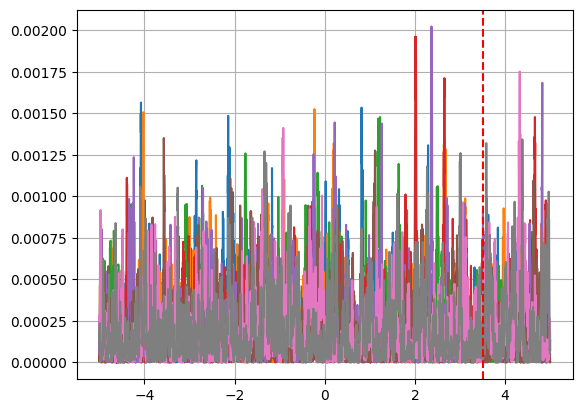

In [82]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [83]:
opr.average_infidelity

1.0

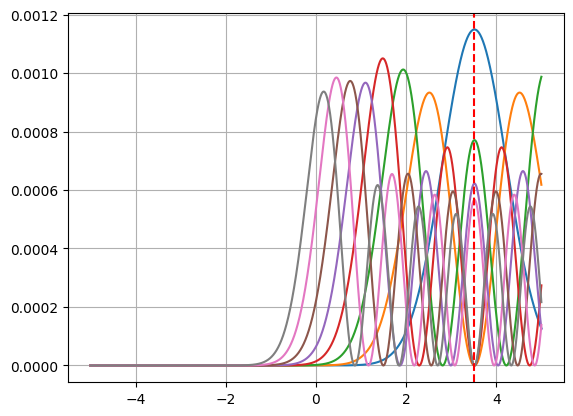

In [84]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

# OPTIMIZATION WITH tsim = 20

In [120]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 5000
tsim = 20
tc = 10
desired_dt = 0.01
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [121]:
optimization_dictionary = {"optimization_client_name": "OptimalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 10
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 5,
           "lower_limit": -5,
           "bins_number": 2000,
           "amplitude_variation": 0.3,
           "time_name": "time_1"}
           
pulse_x["initial_guess"] = {
               "function_type": "lambda_function",
               "lambda_function": "lambda t: 3 * t / 20"
            }

pulse_x["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 2,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.1,
                    "upper_limit": 4.0
                },
                "basis_max": 4.0
            }

#pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

#pulse_x["basis"] = {
#  "basis_name": "Fourier",
#  "basis_vector_number": 5,  # Adjust based on resolution needs
#  "random_super_parameter_distribution": {
#    "distribution_name": "Uniform",
#    "lower_limit": 0.01,
#    "upper_limit": 5.0
#  }
#}


time1 = {"time_name": "time_1",
         "initial_value": 20.0 }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]
optimization_dictionary["shaping_options"] = [
            "add_base_pulse",
            "add_new_update_pulse",
            "add_initial_guess",
            "limit_pulse"
        ]


from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, OptimalControl(opr, par))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.63
INFO     oc_logger    Direct search start time has been reset.


0.01
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.9319217536408171
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.9319217536408171
0.01
INFO     oc_logger    New record achieved. Previous FoM: 0.9319217536408171, new best FoM : 0.905224493265742
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.905224493265742
0.01
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.9129959136978054
0.01
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.9490471743909001
0.01
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.9121299757624308
0.01
INFO     oc_logger    New record achieved. Previous FoM: 0.905224493265742, new best FoM : 0.8934624067576131
INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 1, FoM: 0.8934624067

/tmp/ipykernel_20964/2265382712.py:49: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 27, FoM: 1.0
0.01
INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 27, FoM: 0.7896140445315057
0.01
INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 28, FoM: 0.7414463300005106
0.01
INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 29, FoM: 0.7217595947977616
0.01
INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 30, FoM: 0.9652357727380819
0.01
INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 30, FoM: 0.708062052610384
0.01
INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 31, FoM: 0.7758359965628848
0.01
INFO     oc_logger    New record achieved. Previous FoM: 0.6938537748041222, new best FoM : 0.6432408315130123
INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 31, FoM: 0

Text(0, 0.5, 'Amplitude')

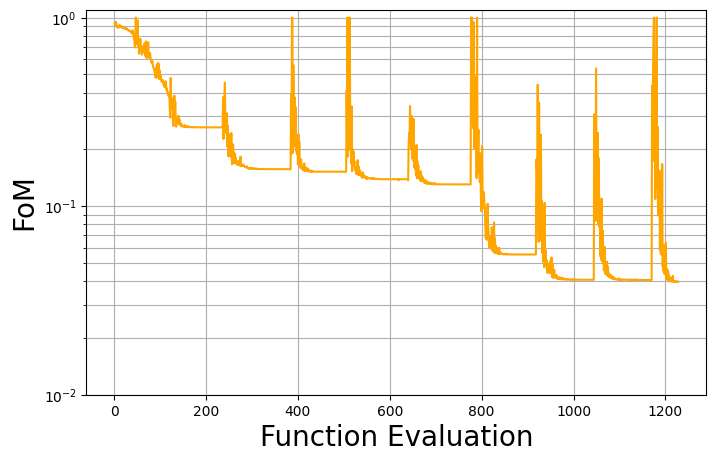

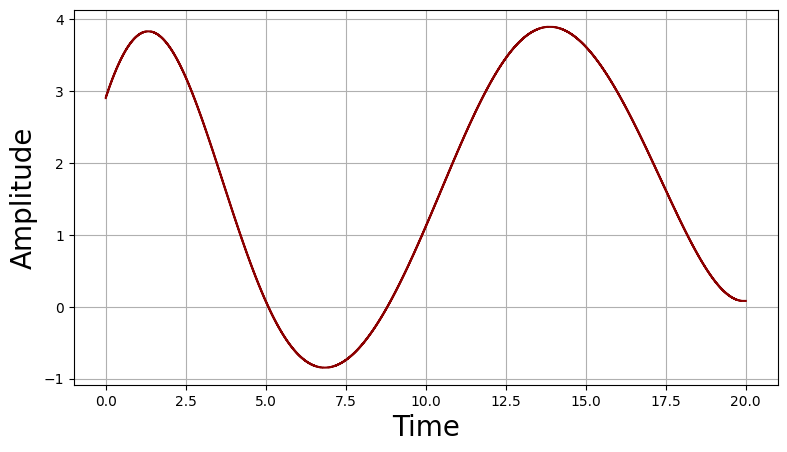

In [141]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax.set_yscale("log")
plt.ylim(0.01, 1.1)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [123]:
pulse

array([2.90320267, 2.91667283, 2.9300569 , ..., 0.08037398, 0.0806865 ,
       0.08107558])

In [ ]:
# SIMULATION PARAMETERS

xmin = -5.0
xmax = 5.0
num_x = 5000
tsim = 20
tc = 10
desired_dt = 0.01
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [130]:
opr.energies

[2.912544997058272, 23.028033382936954, 81.39925329649593, 148.4327775794409]

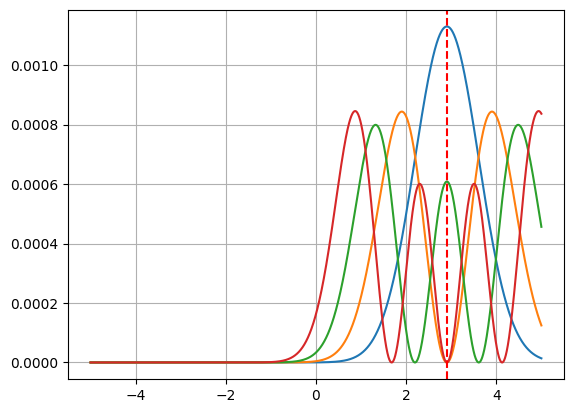

In [131]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [132]:
opr.time_evolution(par, fixed_potential=False)

In [133]:
opr.energies

[436.44669512804677, 636.7648183381154, 1226.599298950157, 1594.7965696443507]

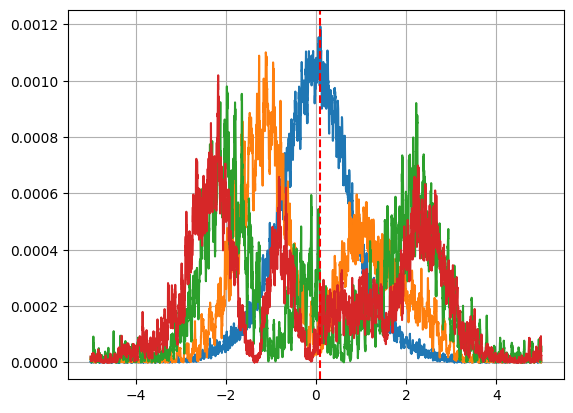

In [134]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [135]:
opr.infidelity()

0.03756132133022108458

In [136]:
opr.time_evolution(par, fixed_potential=True)

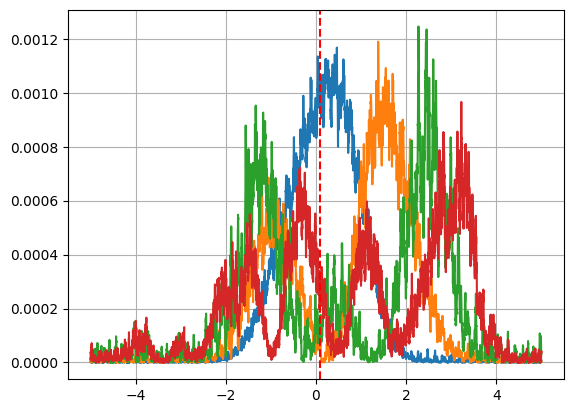

In [137]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

In [138]:
opr.average_infidelity

0.039611237236888181645

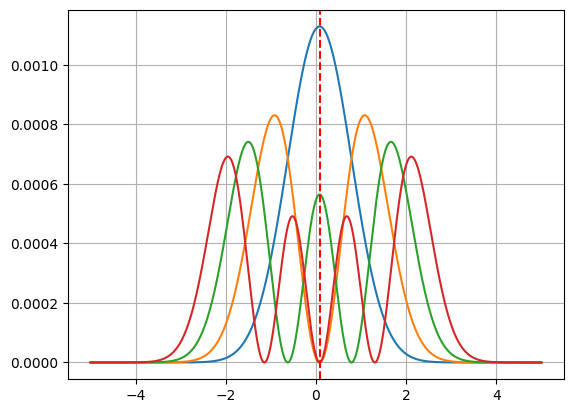

In [139]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(-5.5, 5.5)
plt.grid()
plt.show()

# Simulation with Sigmoid

In [230]:
# SIMULATION PARAMETERS

xmin = -4.0
xmax = 7.0
num_x = 5500
tsim = 15
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [231]:
optimization_dictionary = {"optimization_client_name": "OptimalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 10
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

#optimization_dictionary["algorithm_settings"]["constraint_handling"] = {
#    "method": "hard",
#    "initial_value": 0,
#    "final_value": 3
#}

pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 3,
           "lower_limit": 0,
           "bins_number": num_t,
           "amplitude_variation": 1,
           "time_name": "time_1"}

#pulse_x["scaling_function"] = {
#    "function_type": "lambda_function",
#    "lambda_function": "lambda t: 3 * t / 10"  # Ensures pulse starts at 0 and ends at 3
#}

pulse_x["scaling_function"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 3 * (t / 15)"  # Starts at 0, ends at 3
}

pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t:  3 * t / 15"
}

#pulse_x["scaling_function"] = {
#            "function_type": "python_file",
#            "file_path": "functions.py",
#            "function_name": "shape_function",
#            "path_mode": "relative"
#        }

#pulse_x["basis"] = {
#                "basis_name": "Fourier",
#                "basis_vector_number": 4,
#                "random_super_parameter_distribution": {
#                    "distribution_name": "Uniform",
#                    "lower_limit": 0.1,
#                    "upper_limit": 4.0
#                },
#            }

#pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

pulse_x["basis"] = {
  "basis_name": "Fourier",
  "basis_vector_number": 4,  # Adjust based on resolution needs
  "random_super_parameter_distribution": {
    "distribution_name": "Uniform",
    "lower_limit": 0.1,
    "upper_limit": 4.0
  },
  #"basis_max": 3.0
}


time1 = {"time_name": "time_1",
         "initial_value": tsim }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]
#optimization_dictionary["shaping_options"] = [
#            "add_base_pulse",
#            "add_new_update_pulse",
#            "scale_pulse",
#            "add_initial_guess",
#            "limit_pulse"
#        ]


from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, OptimalControl(opr, par))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.63
INFO     oc_logger    Direct search start time has been reset.
[0.9203802050422737, 6.0793487152576855, 31.672671253497064, 148.39331937813955]
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.3112284119189457
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.3112284119189457
[8.072400971066509, 73.07899022025471, 366.65957747324234, 1075.7620408496898]
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.6674995325613243
[11.128461432835035, 102.90647759907084, 484.0896772123363, 1183.0872900005359]
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.662042861424032
[403.0503229925748, 1469.9632616138224, 2358.939734839107, 3314.1443358841766]
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteratio

/tmp/ipykernel_442/2718060526.py:51: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)
/tmp/ipykernel_442/2718060526.py:23: RuntimeWarning: invalid value encountered in divide
  rho /= np.trace(rho)


[1601.8440030401039, 2977.3076679810138, 4109.522956600147, 4746.828410072531]
INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 2, FoM: 0.9777776306967109
[34.69227604997007, 277.13750205753206, 958.6672049048354, 1759.8124448210106]
INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 2, FoM: 0.7403282816054407
[24.519736811513724, 207.50930075958595, 814.6451507227879, 1730.9803078690622]
INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 3, FoM: 0.7168679436910038
[2184.57208253953, 3782.6801008897583, 4221.600692198051, 4932.389769190134]
INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 4, FoM: 1.0
[10.27725827807916, 94.26192755975762, 456.6115012420468, 1154.1995852800462]
INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 4, FoM: 0.6552703603337338
[64.33820244358985, 465.5074708973696, 1298.1066798198692, 2025.45617000

Text(0, 0.5, 'Amplitude')

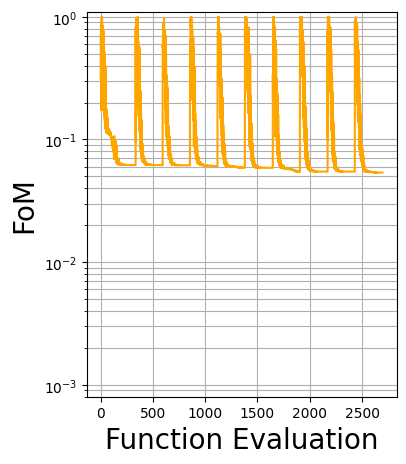

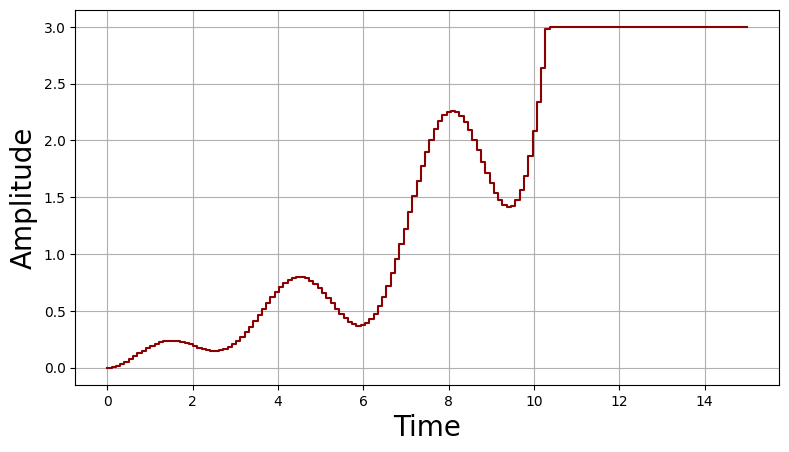

In [232]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax.set_yscale("log")
plt.ylim(0.0008, 1.1)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [233]:
pulse

array([0.        , 0.        , 0.00393059, 0.01503177, 0.03118473,
       0.05140283, 0.07458439, 0.09955986, 0.12514101, 0.15017011,
       0.1735674 , 0.19437494, 0.21179526, 0.22522332, 0.23427062,
       0.23878049, 0.2388341 , 0.23474682, 0.22705515, 0.21649462,
       0.20396957, 0.19051579, 0.17725753, 0.16536037, 0.15598178,
       0.1502213 , 0.14907205, 0.15337567, 0.16378229, 0.18071728,
       0.20435599, 0.23460785, 0.27111034, 0.31323345, 0.36009472,
       0.4105844 , 0.46340021, 0.51709056, 0.57010489, 0.62084945,
       0.66774671, 0.70929624, 0.74413495, 0.7710945 , 0.7892537 ,
       0.79798388, 0.79698544, 0.78631387, 0.76639418, 0.73802261,
       0.70235543, 0.66088447, 0.61540008, 0.56794211, 0.52074047,
       0.47614666, 0.43655854, 0.4043405 , 0.38174168, 0.37081491,
       0.37333906, 0.39074762, 0.42406611, 0.47386059, 0.5401996 ,
       0.62263107, 0.72017566, 0.83133721, 0.95413072, 1.08612751,
       1.22451677, 1.36618207, 1.50779102, 1.64589558, 1.77704

In [234]:
# SIMULATION PARAMETERS

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [235]:
opr.energies

[0.5000220042086041, 1.5007041356954813, 2.510573080636324, 3.5987007104768596]

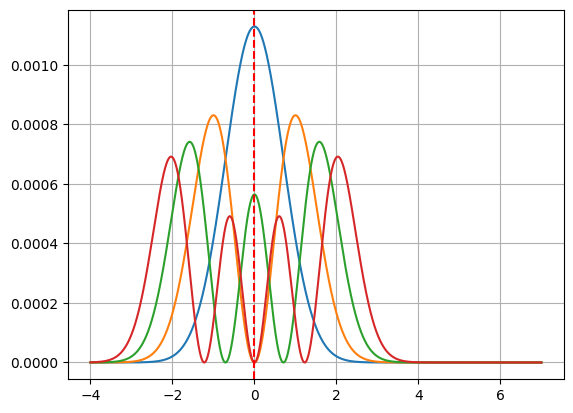

In [236]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.grid()
plt.show()

In [237]:
opr.time_evolution(par, fixed_potential=False)

In [238]:
opr.energies

[0.5032852641374118,
 1.5726039005344024,
 2.9086693170479703,
 14.026495674755287]

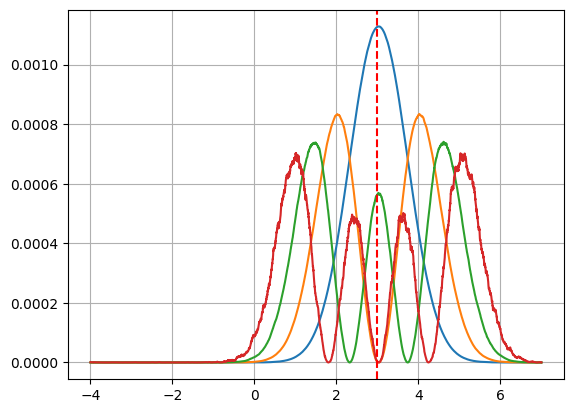

In [239]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [240]:
opr.infidelity()

0.031012629168228784255

In [241]:
opr.time_evolution(par, fixed_potential=True)

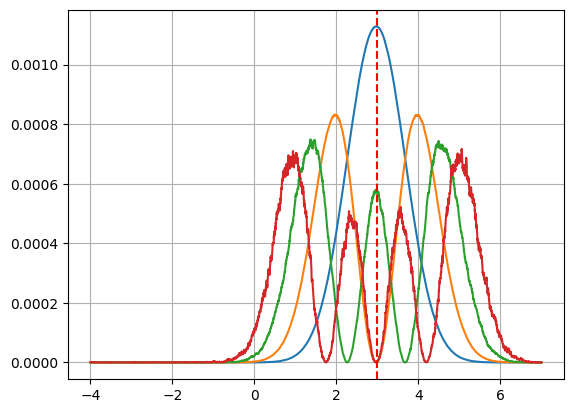

In [242]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [243]:
opr.energies

[0.5076101729772395, 1.665376796150539, 6.922899099849376, 29.560389442955238]

In [244]:
opr.average_infidelity

0.05366062348972482329

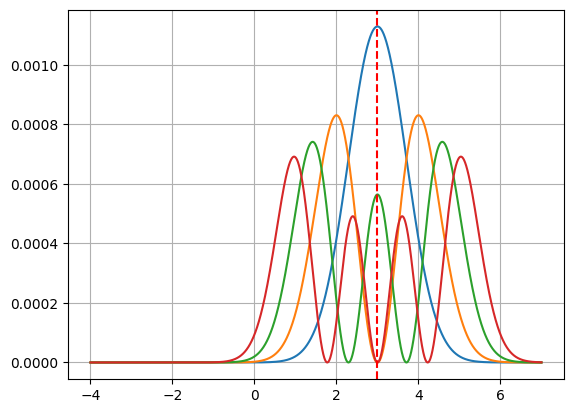

In [245]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [226]:
import re

file_path = './QuOCS_Results/20250215_112628_OptimalControldCRAB/20250215_112628_logging.log'
with open(file_path, 'r') as file:
    # Create a list to store FoM values
    fomlist = []

    # Read each line in the log file
    for line in file:
        # Search for lines that contain "FoM" and extract the FoM value
        match = re.search(r'FoM:\s([0-9\.]+)', line)
        if match:
            fomlist.append(float(match.group(1)))

In [228]:
import zipfile

file_path = './QuOCS_Results/20250215_112628_OptimalControldCRAB/20250215_112628_best_controls.npz'
# Open the .apz file as a ZIP archive
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # List all files inside the archive
    file_names = zip_ref.namelist()
    print("Files inside the archive:", file_names)

    with zip_ref.open('time_grid_for_Pulse_1.npy') as time_file:
      timegrid = np.load(time_file)
    with zip_ref.open('Pulse_1.npy') as file:
      pulse = np.load(file)

Files inside the archive: ['Pulse_1.npy', 'time_grid_for_Pulse_1.npy', 'pulse_names.npy', 'parameter_names.npy', 'time_names.npy', 'FoM.npy', 'iteration_number.npy', 'super_it.npy', 'status_code.npy']


In [230]:
pulse = pulse[::-1]

Text(0, 0.5, 'Amplitude')

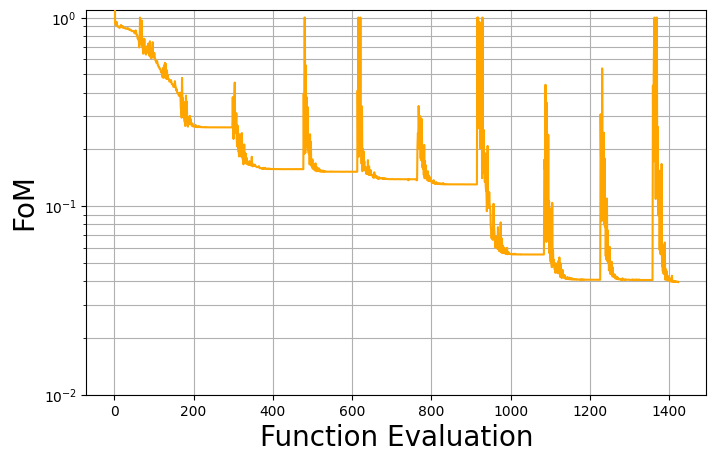

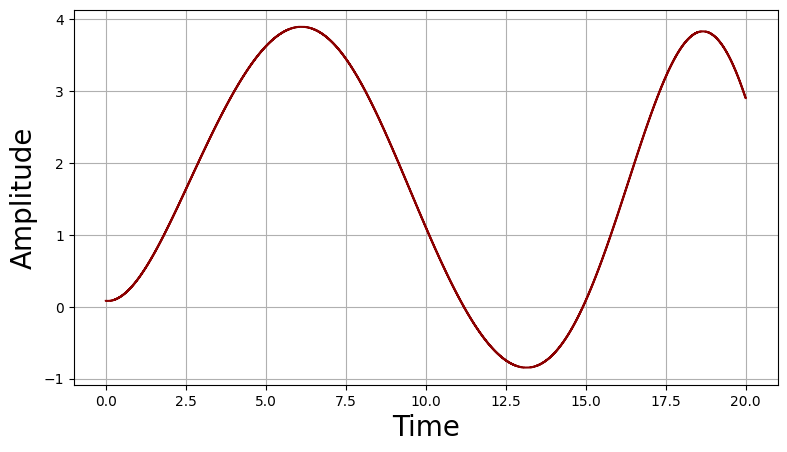

In [231]:
# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax.set_yscale("log")
plt.ylim(0.01, 1.1)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)


# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [544]:
# SIMULATION PARAMETERS

xmin = -10.0
xmax = 10.0
num_x = 10000
tsim = 1
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1
linear_pulse = lambda t: 3 * t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [545]:
opr.energies

[0.499999999999998, 1.4999999999999918, 2.4999999999999827, 3.4999999999999996]

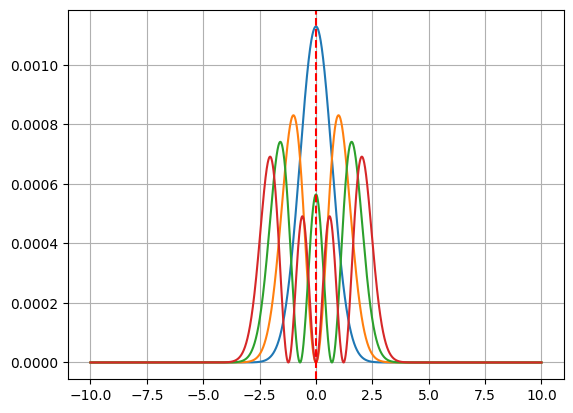

In [546]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.grid()
plt.show()

In [547]:
for row in opr.rho:
  print(" ".join([f"{elem:.6f}" for elem in row]))

0.643914+0.000000j 0.000000+0.000000j 0.000000+0.000000j 0.000000+0.000000j
0.000000+0.000000j 0.236883+0.000000j 0.000000+0.000000j 0.000000+0.000000j
0.000000+0.000000j 0.000000+0.000000j 0.087144+0.000000j 0.000000+0.000000j
0.000000+0.000000j 0.000000+0.000000j 0.000000+0.000000j 0.032059+0.000000j


In [548]:
opr.time_evolution(par, fixed_potential=False)

In [549]:
for row in opr.rho:
  print(" ".join([f"{elem:.6f}" for elem in row]))

0.105682+0.000000j 0.130043-0.071249j 0.075743-0.118454j 0.007106-0.103282j
0.130043+0.071249j 0.232232+0.000000j 0.220982-0.120916j 0.117713-0.183730j
0.075743+0.118454j 0.220982+0.120916j 0.313196+0.000000j 0.273010-0.149293j
0.007106+0.103282j 0.117713+0.183730j 0.273010+0.149293j 0.348889+0.000000j


In [550]:
opr.energies

[4.705183194325554, 5.7051854137887155, 6.705187633251899, 7.705189852715065]

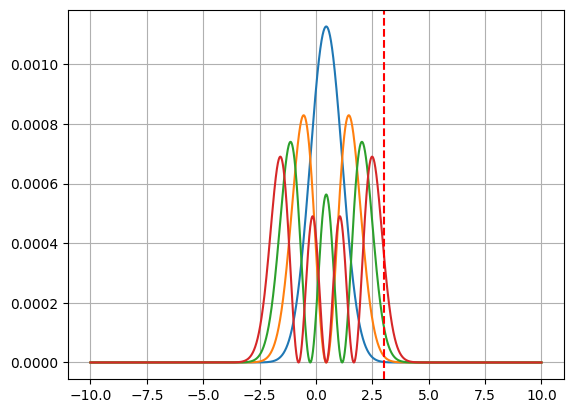

In [551]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [552]:
opr.infidelity()

0.72782483618490179437

In [553]:
for row in opr.rho:
  print(" ".join([f"{elem:.6f}" for elem in row]))

0.105682+0.000000j 0.130043-0.071249j 0.075743-0.118454j 0.007106-0.103282j
0.130043+0.071249j 0.232232+0.000000j 0.220982-0.120916j 0.117713-0.183730j
0.075743+0.118454j 0.220982+0.120916j 0.313196+0.000000j 0.273010-0.149293j
0.007106+0.103282j 0.117713+0.183730j 0.273010+0.149293j 0.348889+0.000000j


In [554]:
opr.time_evolution(par, fixed_potential=True)

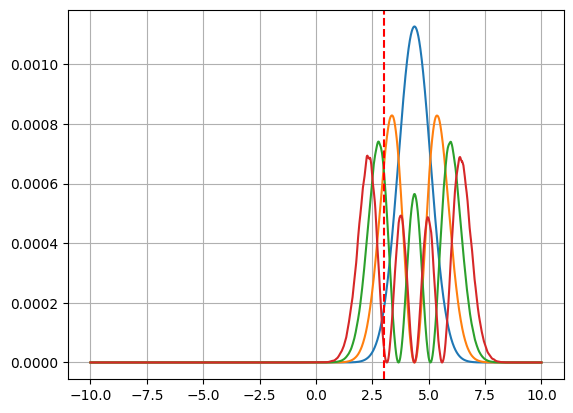

In [555]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [556]:
opr.average_infidelity

0.7303808129358756278

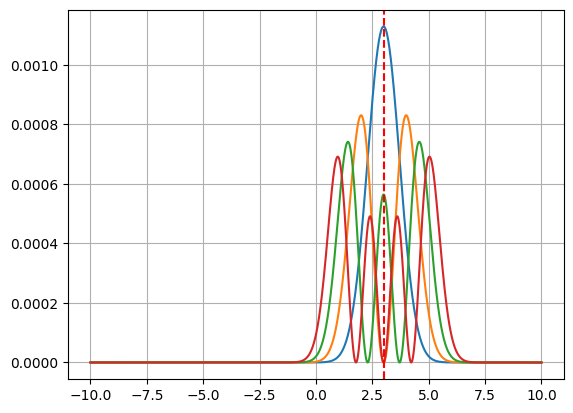

In [557]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [558]:
opr.energies

[4.699445295447034, 5.700258557024085, 6.714854164459891, 7.872946116382003]

In [559]:
for row in opr.rho:
  print(" ".join([f"{elem:.6f}" for elem in row]))

0.103674+0.000000j 0.129298-0.070816j 0.076448-0.119521j 0.007291-0.105734j
0.129298+0.070816j 0.232329+0.000000j 0.222347-0.121689j 0.118967-0.185746j
0.076448+0.119521j 0.222347+0.121689j 0.314575+0.000000j 0.274091-0.149891j
0.007291+0.105734j 0.118967+0.185746j 0.274091+0.149891j 0.349422+0.000000j


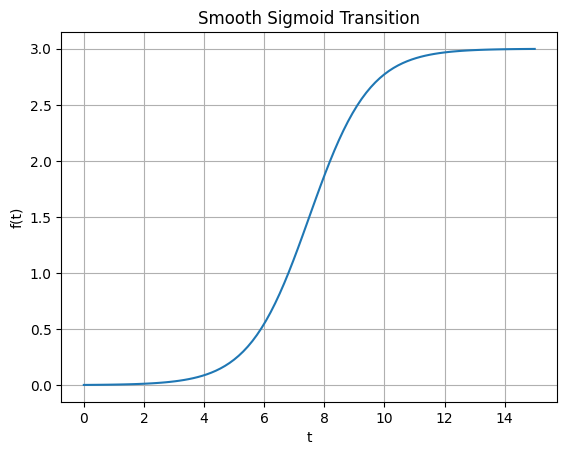

In [211]:
tsim = 15
num_t = 100

def f(t):
    return 3 * (1 / (1 + np.exp(-(t - tsim / 2))))


times = np.linspace(0, tsim, num_t)
values = f(times)

plt.plot(times, values)
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Smooth Sigmoid Transition")
plt.grid()
plt.show()

# SIGMOID AS INITAL GUESS

In [ ]:
# SIMULATION PARAMETERS

xmin = -4.0
xmax = 7.0
num_x = 5500
tsim = 20
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

res = num_x
omega = 1.0
num_wfcs = 4
T = 1
linear_pulse = lambda t: t / tsim
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [ ]:
optimization_dictionary = {"optimization_client_name": "OptimalControldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 10
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000

dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }
    
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings

#optimization_dictionary["algorithm_settings"]["constraint_handling"] = {
#    "method": "hard",
#    "initial_value": 0,
#    "final_value": 3
#}

pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 3,
           "lower_limit": 0,
           "bins_number": num_t,
           "amplitude_variation": 1,
           "time_name": "time_1"}

#pulse_x["scaling_function"] = {
#    "function_type": "lambda_function",
#    "lambda_function": "lambda t: 3 * t / 10"  # Ensures pulse starts at 0 and ends at 3
#}

pulse_x["scaling_function"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 3 * (t / 20)"  # Starts at 0, ends at 3
}

pulse_x["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t:  3 * (t / 20)"
}

#pulse_x["scaling_function"] = {
#            "function_type": "python_file",
#            "file_path": "functions.py",
#            "function_name": "shape_function",
#            "path_mode": "relative"
#        }

#pulse_x["basis"] = {
#                "basis_name": "Fourier",
#                "basis_vector_number": 4,
#                "random_super_parameter_distribution": {
#                    "distribution_name": "Uniform",
#                    "lower_limit": 0.1,
#                    "upper_limit": 4.0
#                },
#            }

#pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

pulse_x["basis"] = {
  "basis_name": "Fourier",
  "basis_vector_number": 4,  # Adjust based on resolution needs
  "random_super_parameter_distribution": {
    "distribution_name": "Uniform",
    "lower_limit": 0.1,
    "upper_limit": 4.0
  },
  #"basis_max": 3.0
}


time1 = {"time_name": "time_1",
         "initial_value": tsim }

optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]
#optimization_dictionary["shaping_options"] = [
#            "add_base_pulse",
#            "add_new_update_pulse",
#            "scale_pulse",
#            "add_initial_guess",
#            "limit_pulse"
#        ]


from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, OptimalControl(opr, par))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.63
INFO     oc_logger    Direct search start time has been reset.
[52.37757381443584, 383.73951410302396, 1156.7474747900917, 1902.21185120917]
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.7654114655396027
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.7654114655396027
[270.63790461406245, 1173.6621738076283, 2080.9615425575844, 2909.0804780896515]
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.8494854682663328
[16.881177995646436, 149.05442035207983, 634.2914549783056, 1388.9540975136124]
INFO     oc_logger    New record achieved. Previous FoM: 0.7654114655396027, new best FoM : 0.6921137107361716
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.6921137107361716
[4.741985337623265, 42.18251463451401, 2

/tmp/ipykernel_442/2718060526.py:51: RuntimeWarning: invalid value encountered in divide
  probs /= np.sum(probs)
/tmp/ipykernel_442/2718060526.py:23: RuntimeWarning: invalid value encountered in divide
  rho /= np.trace(rho)


[2.626131859731, 22.24688820314158, 147.18810767708015, 641.5109952341488]
INFO     oc_logger    Function evaluation number: 844, SI: 4, Sub-iteration number: 5, FoM: 0.5502668709152134
[3.9825834700803897, 34.69926055368481, 201.55084185915848, 731.8101408975579]
INFO     oc_logger    Function evaluation number: 845, SI: 4, Sub-iteration number: 6, FoM: 0.5736172488107443
[0.8965458911766677, 5.476219766963993, 28.07530784749929, 133.95447241158857]
INFO     oc_logger    Function evaluation number: 846, SI: 4, Sub-iteration number: 6, FoM: 0.3004517987789243
[8.227874749959435, 83.33850411876622, 435.2887701686118, 1209.9500940751595]
INFO     oc_logger    Function evaluation number: 847, SI: 4, Sub-iteration number: 7, FoM: 0.6607850390664448
[0.7583039401402717, 4.465780650098574, 21.908754788090988, 95.21995198781745]
INFO     oc_logger    Function evaluation number: 848, SI: 4, Sub-iteration number: 7, FoM: 0.24077646695523577
[3.5834608110321717, 31.668194893329495, 184.072353639

Text(0, 0.5, 'Amplitude')

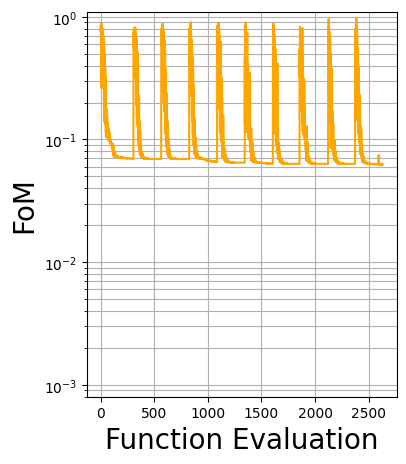

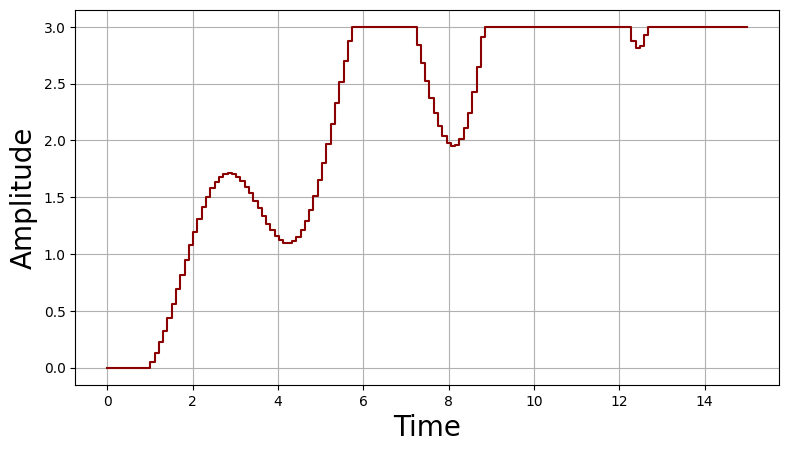

In [250]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(4, 5))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='orange', linewidth=1.5, zorder=10)
#ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax.set_yscale("log")
plt.ylim(0.0008, 1.1)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkred', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)

In [251]:
pulse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04973553, 0.12917774, 0.22168549, 0.32585756,
       0.43990204, 0.56168748, 0.68880486, 0.81863849, 0.94844393,
       1.07543062, 1.1968468 , 1.31006415, 1.41265992, 1.50249371,
       1.57777699, 1.63713297, 1.67964508, 1.70489244, 1.71297131,
       1.70450139, 1.68061694, 1.64294255, 1.59355407, 1.53492575,
       1.46986474, 1.40143473, 1.33287077, 1.26748751, 1.20858345,
       1.15934383, 1.12274488, 1.10146229, 1.09778643, 1.11354701,
       1.15004936, 1.20802443, 1.28759412, 1.38825331, 1.50886932,
       1.64769919, 1.80242466, 1.97020422, 2.14774108, 2.33136552,
       2.51712953, 2.70091144, 2.87852777, 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 2.99722067, 2.84001604, 2.68015

In [252]:
# SIMULATION PARAMETERS

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [253]:
opr.energies

[0.5000220042086041, 1.5007041356954813, 2.510573080636324, 3.5987007104768596]

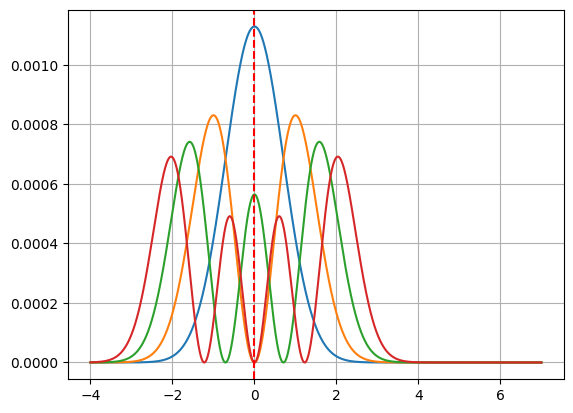

In [254]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.grid()
plt.show()

In [255]:
opr.time_evolution(par, fixed_potential=False)

In [256]:
opr.energies

[0.5041736775126329, 1.588253081681929, 3.086642138679618, 15.65415138009329]

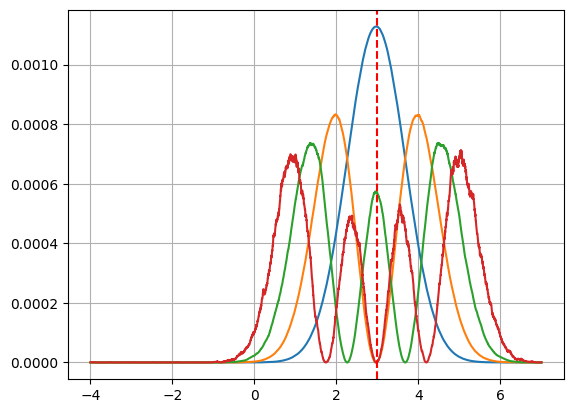

In [257]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [258]:
opr.infidelity()

0.032778987824786520483

In [259]:
opr.time_evolution(par, fixed_potential=True)

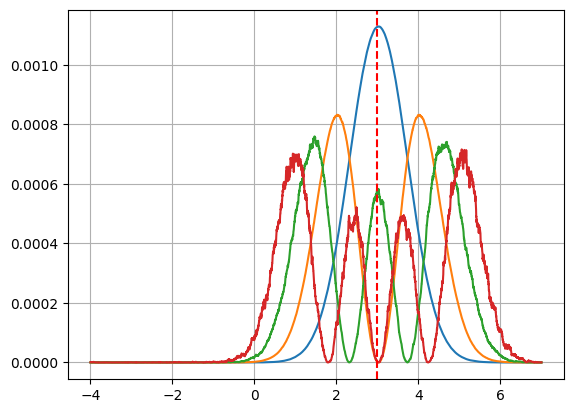

In [260]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()

In [261]:
opr.energies

[0.5081208188250681, 1.6783700018015595, 7.957023376841198, 34.05927472647864]

In [262]:
opr.average_infidelity

0.062245591515429076424

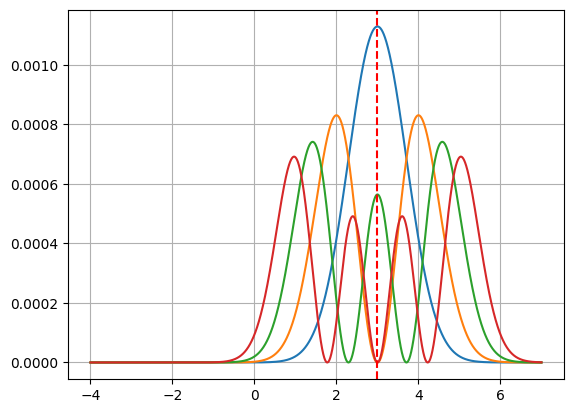

In [263]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.grid()
plt.show()